In [2]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [2]:
!pip3 install Pysyft

In [3]:
!pip install syft=="0.2.2a1"
!pip install syft_proto=="0.1.1a1.post17"

     |████████████████████████████████| 337kB 29.6MB/s 
     |████████████████████████████████| 112kB 49.6MB/s 
     |████████████████████████████████| 773.1MB 21kB/s 
     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 532kB 51.5MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 2.1MB 42.7MB/s 
     |████████████████████████████████| 10.2MB 12.6MB/s 
     |████████████████████████████████| 1.8MB 35.9MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=001b5618efde238a8875bf47747dcf54da1dc0d257539ef1a49d6ff5c9687293
  Stored in directory: /root/.cache/pip/wheels/f8/dc/36/dcb6bf0f1b9907e7b710ace63e64d08e7022340909315fdea4
  Created wheel for zstd: filename=zstd-1.5.0.2-cp37-cp37m-linux_x86_64.whl size=1672596 sha256=7663e209d0bcfd8ce584d90ab86727651cfc8a6

     |████████████████████████████████| 40kB 5.7MB/s 
  Found existing installation: syft-proto 0.5.3
    Uninstalling syft-proto-0.5.3:
      Successfully uninstalled syft-proto-0.5.3


In [1]:
import syft as sy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
anne = sy.VirtualWorker(hook, id="anne")

In [ ]:
x = torch.Tensor([2,2,2]).send(bob)
print(x)

(Wrapper)>[PointerTensor | me:86956231882 -> bob:3094165622]


In [ ]:
def load_data():
    
    '''<--Load CIFAR dataset from torch vision module distribute to workers using PySyft's Federated Data loader'''
    

    federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    return federated_train_loader,test_loader

In [ ]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 200
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
#<--Load federated training data and test data
federated_train_loader,test_loader=load_data()

#<--Create Neural Network model instance
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) #<--TODO momentum is not supported at the moment

#<--Train Neural network and validate with test set after completion of training every epoch
for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "cifar10_cnn.pt")


0it [00:00, ?it/s]



Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ../data/cifar-10-python.tar.gz


0it [00:00, ?it/s]

  0%|          | 49152/170498071 [00:00<06:26, 440993.81it/s]

  0%|          | 237568/170498071 [00:00<04:57, 571926.19it/s]

  0%|          | 425984/170498071 [00:00<03:55, 722926.63it/s]

  0%|          | 614400/170498071 [00:00<03:12, 884044.47it/s]

  0%|          | 802816/170498071 [00:00<02:41, 1047902.51it/s]

  1%|          | 991232/170498071 [00:00<02:20, 1207996.21it/s]

  1%|          | 1179648/170498071 [00:00<02:05, 1346896.32it/s]

  1%|          | 1368064/170498071 [00:00<01:55, 1470601.01it/s]

  1%|          | 1556480/170498071 [00:00<01:48, 1560228.34it/s]

  1%|          | 1744896/170498071 [00:01<01:43, 1635685.54it/s]

  1%|          | 1933312/170498071 [00:01<01:39, 1700856.71it/s]

  1%|          | 2121728/170498071 [00:01<01:36, 1744656.16it/s]

  1%|▏         | 2310144/170498071 [00:01<01:37, 1732735.40it/s]

  1%|▏         | 2490368/170498071 [00:01<01:37, 1714860.01it/s]

  2%|▏         | 2670592/170498071 [00:01<01:37, 1723673.82it/s]

 

Extracting ../data/cifar-10-python.tar.gz to ../data




170500096it [01:39, 9230111.01it/s]                               

Train Epoch: 1 [0/50048 (0%)]	Loss: 2.310682
Train Epoch: 1 [12800/50048 (26%)]	Loss: 2.301998
Train Epoch: 1 [25600/50048 (51%)]	Loss: 2.293859
Train Epoch: 1 [38400/50048 (77%)]	Loss: 2.298970

Test set: Average loss: 2.2804, Accuracy: 1528/10000 (15%)

Train Epoch: 2 [0/50048 (0%)]	Loss: 2.285189
Train Epoch: 2 [12800/50048 (26%)]	Loss: 2.214281
Train Epoch: 2 [25600/50048 (51%)]	Loss: 2.174301
Train Epoch: 2 [38400/50048 (77%)]	Loss: 1.991645

Test set: Average loss: 1.9646, Accuracy: 2947/10000 (29%)

Train Epoch: 3 [0/50048 (0%)]	Loss: 1.924952
Train Epoch: 3 [12800/50048 (26%)]	Loss: 1.949415
Train Epoch: 3 [25600/50048 (51%)]	Loss: 1.895669
Train Epoch: 3 [38400/50048 (77%)]	Loss: 1.820386

Test set: Average loss: 1.7785, Accuracy: 3498/10000 (35%)

Train Epoch: 4 [0/50048 (0%)]	Loss: 1.611385
Train Epoch: 4 [12800/50048 (26%)]	Loss: 1.611142
Train Epoch: 4 [25600/50048 (51%)]	Loss: 1.711248
Train Epoch: 4 [38400/50048 (77%)]	Loss: 1.616658

Test set: Average loss: 1.6442, Accu

# New Project

In [4]:
import pickle
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import TensorDataset,DataLoader
import time 
import copy
import numpy as np

In [5]:
class parser:
    def __init__(self):
        self.epochas = 100 
        self.lr = 0.001 
        self.test_batch_size  = 8
        self.batch_size = 8 
        self.log_interval = 10
        self.seed = 1

args = parser()
torch.manual_seed(args.seed)

In [12]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()
print( "Type of boston dataset:", type(boston))
boston_df = pd.DataFrame(boston['data'] )
boston_df.head()

Type of boston dataset: <class 'sklearn.utils.Bunch'>


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [13]:
boston_df['PRICE']= boston['target']
boston_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


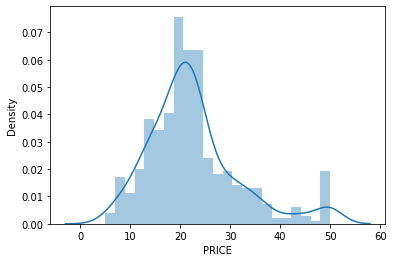

In [14]:
import seaborn as sns
sns.distplot(boston_df['PRICE']);

In [17]:
y = boston_df['PRICE']
#As we know, iloc is used to slice the array by index number. Here this is the matrix of 
#independent variables.
X = boston_df.iloc[:,0:13]
X, X_test, y, y_test = train_test_split(X, y,random_state=0)

In [18]:
print(X.shape, X_test.shape, y.shape, y_test.shape)

(379, 13) (127, 13) (379,) (127,)


In [72]:

with open('/content/boston_housing (1).pickle','rb') as f:
    ((x, y), (x_test, y_test)) = pickle.load(f)

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [73]:

mean = x.mean(0, keepdim=True)
dev = x.std(0, keepdim=True)
mean[:, 3] = 0.
dev[:, 3] = 1.
x = (x - mean) / dev
x_test = (x_test - mean) / dev
train = TensorDataset(x, y)
test = TensorDataset(x_test, y_test)
train_loader = DataLoader(train, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=args.test_batch_size, shuffle=True)

# Net

In [164]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 32)
        self.fc2 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 16)
        self.fc5 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = x.view(-1, 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc3(x)
        return x

In [215]:
hook = sy.TorchHook(torch)
bob_worker = sy.VirtualWorker(hook, id="bob")
alice_worker = sy.VirtualWorker(hook, id="alice")
# kwargs_websocket = {"host": "localhost", "hook": hook}
# alice = WebsocketClientWorker(id='alice', port=8779, **kwargs_websocket)
# bob = WebsocketClientWorker(id='bob', port=8778, **kwargs_websocket)
compute_nodes = [bob_worker, alice_worker]

In [216]:
remote_dataset  = (list(),list())
train_distributed_dataset = [] 

for batch_idx, (data,target) in enumerate(train_loader):
    data = data.send(compute_nodes[batch_idx % len(compute_nodes)]) # data transfer
    target = target.send(compute_nodes[batch_idx % len(compute_nodes)]) # label transfer !!

    remote_dataset[batch_idx % len(compute_nodes)].append((data, target))

In [217]:
print(remote_dataset)

([((Wrapper)>[PointerTensor | me:22003907274 -> bob:55029087831], (Wrapper)>[PointerTensor | me:99222406331 -> bob:97412054298]), ((Wrapper)>[PointerTensor | me:26486779919 -> bob:72940171827], (Wrapper)>[PointerTensor | me:76186238317 -> bob:68000133495]), ((Wrapper)>[PointerTensor | me:53430646145 -> bob:37929698228], (Wrapper)>[PointerTensor | me:2122518635 -> bob:56022628497]), ((Wrapper)>[PointerTensor | me:63030930289 -> bob:48115935841], (Wrapper)>[PointerTensor | me:12809416235 -> bob:46269849028]), ((Wrapper)>[PointerTensor | me:56496921343 -> bob:10956667459], (Wrapper)>[PointerTensor | me:88697572652 -> bob:9455632885]), ((Wrapper)>[PointerTensor | me:38142654742 -> bob:70146131947], (Wrapper)>[PointerTensor | me:31263681012 -> bob:6625964152]), ((Wrapper)>[PointerTensor | me:62295122350 -> bob:61512714666], (Wrapper)>[PointerTensor | me:47165150903 -> bob:38637953738]), ((Wrapper)>[PointerTensor | me:38134635442 -> bob:95306123097], (Wrapper)>[PointerTensor | me:12902840437

In [218]:
bobs_model = Net()
alices_model = Net()
bobs_optimizer = optim.SGD(bobs_model.parameters(), lr=args.lr)
alices_optimizer = optim.SGD(alices_model.parameters(), lr=args.lr)

In [219]:
models = [bobs_model, alices_model]
optimizers = [bobs_optimizer, alices_optimizer]

In [220]:
model = Net()
model

Net(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

# def update

In [221]:
def update(data, target, model, optimizer):
    model.send(data.location) # tranafer model to clients
    optimizer.zero_grad()
    prediction = model(data) # خروجی های مدل
    loss = F.mse_loss(prediction.view(-1), target)
    loss.backward()
    optimizer.step()
    return model

# def train

In [222]:
#from syft.frameworks.torch.federated import utils
from syft.frameworks.torch.fl import utils # خدایا تو شاهد باش :

In [223]:
def train():
    for data_index in range(len(remote_dataset[0])-1):
        for remote_index in range(len(compute_nodes)):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        for model in models:
            model.get()
        return utils.federated_avg({"bob": models[0],"alice": models[1]}) 


#return of the train function is a federated_avg !! not model !!!

# def test

In [224]:
test_loss_ls = []
def test(federated_model):
    federated_model.eval()
    test_loss = 0
    for data, target in test_loader:
        output = federated_model(data)
        test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()
        test_loss_ls.append(test_loss)
        predection = output.data.max(1, keepdim=True)[1]
        
    test_loss /= (len(test_loader.dataset))
    print(test_loss)
    print('Test set: Average loss: {:.4f}'.format(test_loss))

# Start

In [186]:

for epoch in range(100): # 100 epochs
    start_time = time.time()
    print(f"Epoch Number {epoch + 1}")
    federated_model = train()
    model = federated_model
    test(federated_model)
    total_time = time.time() - start_time
    print('Communication time over the network', round(total_time, 2), 's\n')


Epoch Number 1
Test set: Average loss: 598.6571
Communication time over the network 0.09 s

Epoch Number 2
Test set: Average loss: 595.0490
Communication time over the network 0.08 s

Epoch Number 3
Test set: Average loss: 591.3054
Communication time over the network 0.09 s

Epoch Number 4
Test set: Average loss: 587.6210
Communication time over the network 0.08 s

Epoch Number 5
Test set: Average loss: 584.1529
Communication time over the network 0.08 s

Epoch Number 6
Test set: Average loss: 580.7343
Communication time over the network 0.08 s

Epoch Number 7
Test set: Average loss: 577.2906
Communication time over the network 0.08 s

Epoch Number 8
Test set: Average loss: 573.7587
Communication time over the network 0.08 s

Epoch Number 9
Test set: Average loss: 570.0982
Communication time over the network 0.09 s

Epoch Number 10
Test set: Average loss: 566.2696
Communication time over the network 0.09 s

Epoch Number 11
Test set: Average loss: 562.2350
Communication time over the ne

# Why when i test(federated_model) it get me a "24%" loss but when i test(model) it get me a "40%" loss ??

my_opinion --->

fed_avg > model_based

In [197]:
for epoch in range(100): # 100 epochs
    start_time = time.time()
    print(f"Epoch Number {epoch + 1}")
    federated_model = train()
    model = federated_model
    test(model) # replace with test(federated_model) !!!!
    total_time = time.time() - start_time
    print('Communication time over the network', round(total_time, 2), 's\n')


Epoch Number 1
Test set: Average loss: 615.1656
Communication time over the network 0.1 s

Epoch Number 2
Test set: Average loss: 615.8757
Communication time over the network 0.08 s

Epoch Number 3
Test set: Average loss: 615.1978
Communication time over the network 0.08 s

Epoch Number 4
Test set: Average loss: 613.6924
Communication time over the network 0.08 s

Epoch Number 5
Test set: Average loss: 611.8409
Communication time over the network 0.08 s

Epoch Number 6
Test set: Average loss: 609.8032
Communication time over the network 0.09 s

Epoch Number 7
Test set: Average loss: 607.6606
Communication time over the network 0.09 s

Epoch Number 8
Test set: Average loss: 605.4599
Communication time over the network 0.08 s

Epoch Number 9
Test set: Average loss: 603.2204
Communication time over the network 0.08 s

Epoch Number 10
Test set: Average loss: 600.9518
Communication time over the network 0.09 s

Epoch Number 11
Test set: Average loss: 598.6574
Communication time over the net

نکته جالب که بعد از سعی و خطای بسیار فهمیدم این است که وقتی برای اولین بار ران میکنید به خطا و روند معقول میرسید ولی بعد از ترین وقتی تعداد ایپاک هارا زیاد میکنید میبینید که خطای ثابت دارید!!! یعنی این که کلاینت ها چیزی لرن نمیکنن بلکه دارن فقط عدد پرینت میکنن!! برای جلوگیری از این کار باید از دوباره عمل هوک کردن را انجام دهیم!!

In [227]:
test_loss_ls

[6996.75732421875,
 10841.630615234375,
 16221.296142578125,
 22387.565185546875,
 26213.59765625,
 29679.62353515625,
 36062.55126953125,
 41011.6513671875,
 44205.255859375,
 49864.83984375,
 55777.35986328125,
 60925.59814453125,
 63800.472412109375,
 4922.52880859375,
 10209.68701171875,
 15667.3388671875,
 18774.265380859375,
 22716.690673828125,
 27181.386962890625,
 32328.671142578125,
 40765.988525390625,
 44762.313720703125,
 50085.448486328125,
 53927.67626953125,
 58153.64794921875,
 63153.18798828125,
 2691.893798828125,
 8605.488525390625,
 13513.420654296875,
 17016.8564453125,
 23095.04833984375,
 29079.92041015625,
 34171.1923828125,
 42374.494140625,
 45183.31591796875,
 52281.7568359375,
 56540.6103515625,
 59749.681884765625,
 62522.51513671875,
 3477.7490234375,
 8328.392578125,
 14949.40625,
 21923.11767578125,
 26769.0009765625,
 33778.90625,
 38286.7333984375,
 43251.4033203125,
 48401.8505859375,
 52650.25341796875,
 55217.24365234375,
 58571.43798828125,
 61967